# Quantization in Depth
The goal of this notebook is to provide an in depth understanding of Quantization, its theory, use cases, and implementation. The concepts, and instruction within this notebook are used from the [DeepLearning.AI](https://www.deeplearning.ai) course: [Quantization in Depth](https://learn.deeplearning.ai/courses/quantization-in-depth/lesson/1/introduction). I highly recommend watching, and completing this course on your own time. However, I wanted to provide an all-in-one notebook, including my insights as I take the course for those who may be interested.

***
## Outline:
### Linear Quantization
This Notebook aims to help gain an understanding of Linear Quantization. By deep diving into the internals of linear quantization and implementing the variance from scratch (per channel, tensor, and group quantization) we should be able to study the advantages/drawbacks for each method and their impacts on some example tensors.
<br><br>
### BYO 8-Bit Quantizer
Building our own quantizer to quantize any model in 8-bit precision using one of the quantization schemes presented before. Quantization schemes are agnostic to modality, meaning: it can be applied to any model as long as it contains linear layers. technically your quantizer will be able to quantize a vision, text, audio, or even a multimodal model.

### Quantization Packages
Learn more about challenges that can be faced regarding extreme quantization such as weight packing or challenges regarding LLM quantization. 

# <font color=orange>Linear Quantization I-A: Quantize and De-quantize a Tensor</font>
In this lesson, you will learn the fundamentals of linear quantization.

In [1]:
import torch
from helper import plot_quantization_errors

## Quantization with Random Scale and Zero Point
* Implement Linear Quantization for when the "scale" and the "zero point" are known/randomly selected. <br>

***Linear Quantization Formula:***
**<font color=orange>r</font>** = original value (input/high-bit), **<font color=purple>s</font>** = Scale (input/high-bit)
**<font color=red>q</font>** = quantized value (output/Low-bit), **<font color=olive>z</font>** = zero point
$ r = s(q - z) $ or $ q = int(round(r/s + z)) $

In [2]:
def linear_q_with_scale_and_zero_point(tensor, scale, zero_point, dtype = torch.int8):

    scaled_and_shifted_tensor = tensor / scale + zero_point

    rounded_tensor = torch.round(scaled_and_shifted_tensor)

    q_min = torch.iinfo(dtype).min
    q_max = torch.iinfo(dtype).max

    q_tensor = rounded_tensor.clamp(q_min,q_max).to(dtype)
    
    return q_tensor

In [3]:
test_tensor=torch.tensor(
    [[191.6, -13.5, 728.6],
     [92.14, 295.5,  -184],
     [0,     684.6, 245.5]]
)

In [4]:
### these are random values for "scale" and "zero_point"
### to test the implementation
scale = 3.5
zero_point = -70

In [5]:
quantized_tensor = linear_q_with_scale_and_zero_point(test_tensor, scale, zero_point)
quantized_tensor

tensor([[ -15,  -74,  127],
        [ -44,   14, -123],
        [ -70,  126,    0]], dtype=torch.int8)

In [6]:
# What happens if we do not cast the quantized tensor to float?
dequantized_tensor = scale * (quantized_tensor - zero_point)
dequantized_tensor

tensor([[ 192.5000,  -14.0000, -206.5000],
        [  91.0000,  294.0000, -185.5000],
        [   0.0000, -210.0000,  245.0000]])

In [7]:
# CORRECT implementation: casting quantized tensor to float
def linear_dequantization(quantized_tensor, scale, zero_point):
    return scale * (quantized_tensor.float() - zero_point)

dequantized_tensor = linear_dequantization(quantized_tensor, scale, zero_point)
dequantized_tensor

tensor([[ 192.5000,  -14.0000,  689.5000],
        [  91.0000,  294.0000, -185.5000],
        [   0.0000,  686.0000,  245.0000]])

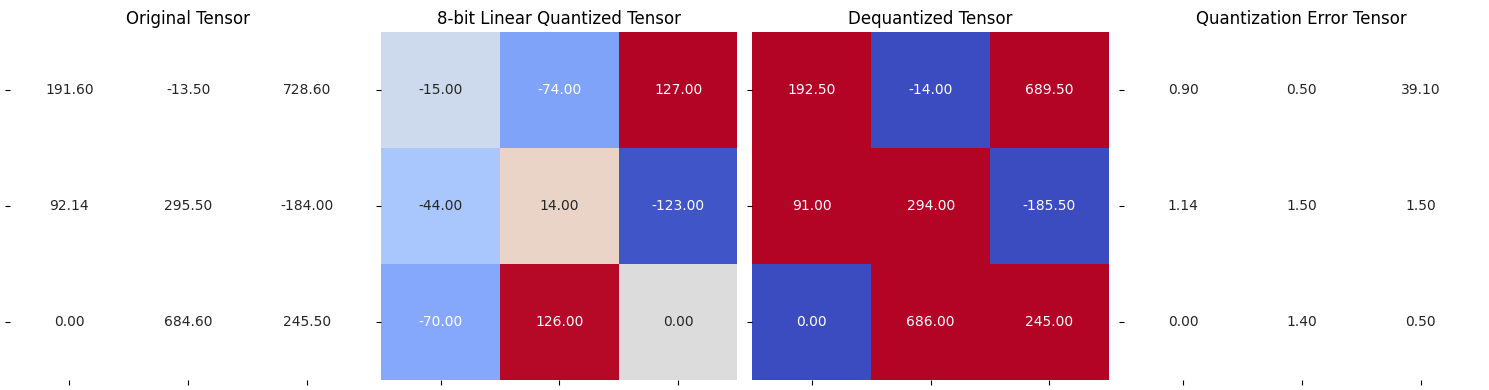

In [8]:
plot_quantization_errors(test_tensor, quantized_tensor, dequantized_tensor)

In [9]:
# Quantization Error: Calculate an "overall" quantization error by using Mean Squared Error technique.
(dequantized_tensor - test_tensor).square().mean()

tensor(170.8753)

In [10]:
def quantization_mse(dequantized_tensor, tensor):
    print(f"Quantization Mean Squared Error: {(dequantized_tensor - tensor).square().mean()}")

In [11]:
q_error = quantization_mse(dequantized_tensor, test_tensor)
q_error

Quantization Mean Squared Error: 170.87530517578125


***Quantization Error: <font color=red>170.8753</font>***
This error is considered to be quite high however this is due to the randomly assigned zero-point and scale values. In the next sections we'll cover how to derive closer or exact values
<br>
#### Advantages of Quantization
* Smaller Model
* Speed Increase:
  * Memory Bandwidth
  * Faster Operations:
      * GEMM: General Matrix Multiply (matrix to matrix multiplication)
      * GEMV: General Matrix Multiply (matrix to vector multiplication)

# <font color=orange>Linear Quantization I-B: Get the Scale and Zero Point</font>
In this lesson, continue to learn about fundamentals of linear quantization, and implement your own Linear Quantizer.

#### ***Scale and Zero-Point***
If we look at extreme values we should get:
$ r_{min} = s(q_{min}- z) $ 
$ r_{max} = s(q_{max}- z) $ 

subtracting the first equation from the second we get the scale s:
$ s = (r_{max} - r_{min}) / (q_{max} - q_{min})$

for the zero point we need to round the value:
$ z = int(round(q_{min} - (r_{min}/s))) $
*The goal is to represent 0 in the original 'r' range with an integer in the quantized 'q' range*

Therefore, for our previous example:
$ s = (728.6 - (-184)) / (127 - (-128)) >> 912/255 >>s = 3.58$
$ z = int(round((-128) - (-184)/3.58) >> int(round((-128) - (-51.4))) >> int(round(-76.6)) >> z = -77$

What do you do if the zero point is out of range?
case 1: (z < q_min) >> set z = q_min
case 2: (z > q_max) >> set z = q_max
*This elminiates overflow and underflow*

In [12]:
q_min = torch.iinfo(torch.int8).min
q_max = torch.iinfo(torch.int8).max
print(f"q_min: {q_min}, q_max: {q_max}")

q_min: -128, q_max: 127


In [13]:
r_min = test_tensor.min().item()
r_max = test_tensor.max().item()
print(f"r_min: {r_min}, r_max: {r_max}")

r_min: -184.0, r_max: 728.5999755859375


In [14]:
scale = (r_max - r_min) / (q_max - q_min)
print(f"scale: {scale}")

scale: 3.578823433670343


In [15]:
zero_point = int(round(q_min - (r_min/scale)))
print(f"zero_point: {zero_point}")

zero_point: -77


In [16]:
def get_q_scale_and_zero_point(tensor, dtype=torch.int8):
    q_min, q_max = torch.iinfo(dtype).min, torch.iinfo(dtype).max
    r_min, r_max = tensor.min().item(), tensor.max().item()
    scale = (r_max - r_min) / (q_max - q_min)
    zero_point = (q_min - (r_min/scale))
    if zero_point < q_min:
        zero_point = q_min
    elif zero_point > q_max:
        zero_point = q_max
    else:
        zero_point = int(round(zero_point))
        
    return scale, zero_point

In [17]:
new_scale , new_zero_point = get_q_scale_and_zero_point(test_tensor)
print(f"new_scale: {new_scale}, new_zero_point: {new_zero_point}")

new_scale: 3.578823433670343, new_zero_point: -77


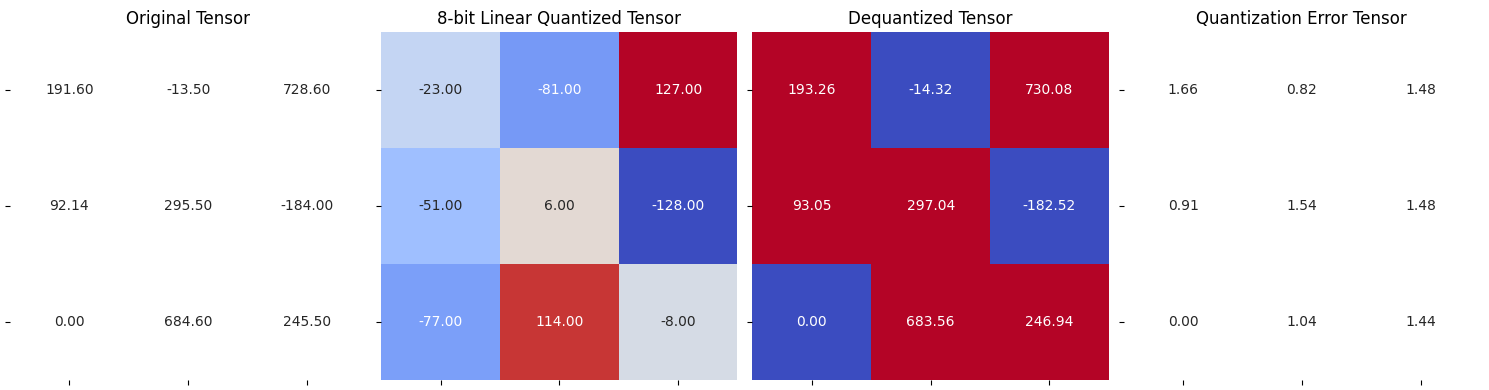

In [18]:
quantized_tensor = linear_q_with_scale_and_zero_point(test_tensor, new_scale, new_zero_point)
dequantized_tensor = linear_dequantization(quantized_tensor, new_scale, new_zero_point)
plot_quantization_errors(test_tensor, quantized_tensor,dequantized_tensor)

In [19]:
(dequantized_tensor - test_tensor).square().mean()

tensor(1.5730)

In [20]:
def linear_quantization(tensor, dtype=torch.int8):
    scale, zero_point = get_q_scale_and_zero_point(tensor, dtype=dtype)
    quantized_tensor = linear_q_with_scale_and_zero_point(tensor, scale, zero_point, dtype=dtype)
    return quantized_tensor, scale, zero_point

In [21]:
r_tensor = torch.randn((4,4))
r_tensor

tensor([[-0.8523, -0.1767,  2.5253, -0.7584],
        [-0.3939, -0.7848,  0.9676, -1.1990],
        [ 0.3829, -1.2540,  0.0957, -0.5347],
        [-0.5669, -1.8098,  0.2362,  0.1313]])

In [22]:
quantized_tensor, scale, zero_point = linear_quantization(r_tensor)
quantized_tensor

tensor([[ -72,  -32,  127,  -67],
        [ -45,  -68,   35,  -93],
        [   1,  -96,  -16,  -53],
        [ -55, -128,   -8,  -14]], dtype=torch.int8)

In [23]:
scale

0.017000269889831544

In [24]:
zero_point

-22

In [25]:
dequantized_tensor = linear_dequantization(quantized_tensor, scale, zero_point)

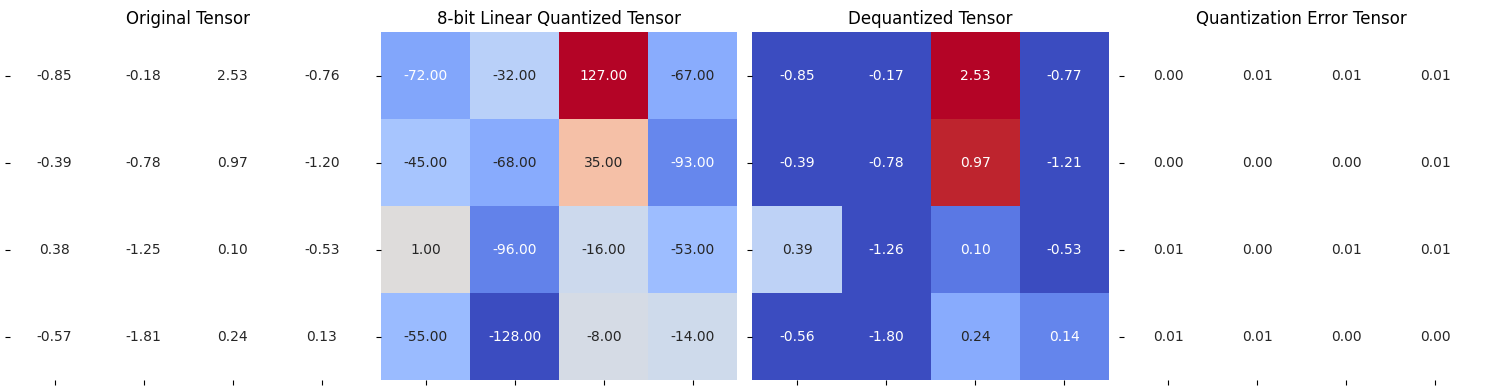

In [26]:
plot_quantization_errors(r_tensor, quantized_tensor, dequantized_tensor)

In [27]:
quantization_mse(dequantized_tensor, r_tensor)

Quantization Mean Squared Error: 3.345123695908114e-05


### Custom Attempt at Batch Normalization Quantization
Turns out specifically, this class uses per channel quantization (per row)

In [28]:
class BatchTensor:
    def __init__(self, tensor, dtype):
        # TENSORS
        self.tensor = tensor
        self.quantized_tensor = None
        self.dequantized_tensor = None
        
        # VARIABLES
        self.dtype = dtype
        self.rmin = self.tensor.min().item()
        self.rmax = self.tensor.max().item()
        self.qmin = torch.iinfo(self.dtype).min
        self.qmax = torch.iinfo(self.dtype).max
        self.scale = []
        self.zero_point = []
        
        # MISCELLANEOUS
        self.rows_size = tensor.size(0)
        self.cols_size = tensor.size(1)
        self.mse_tensor = None
        
    def get_batch_scales_and_zeropoints(self):
        if self.scale or self.zero_point:
            self.clear()
        for i in range(self.rows_size):
            a, b = get_q_scale_and_zero_point(self.tensor[i])
            self.scale.append(a), self.zero_point.append(b)
            
    def linear_batch_quantization(self):
        self.quantized_tensor = torch.zeros(self.rows_size, self.cols_size)
        for i in range(self.rows_size):
            self.quantized_tensor[i] = linear_q_with_scale_and_zero_point(self.tensor[i], self.scale[i], self.zero_point[i])
    
    def linear_batch_dequantization(self):
        self.dequantized_tensor = torch.zeros(self.rows_size, self.cols_size)
        for i in range(self.rows_size):
            self.dequantized_tensor[i] = linear_dequantization(self.quantized_tensor[i], self.scale[i], self.zero_point[i])
            
    def batch_quantization_mse(self):
        return (bt.dequantized_tensor - bt.tensor).square().mean()
            
    def clear(self):
        self.scale.clear()
        self.zero_point.clear()

In [29]:
t = torch.randn((4,4))
bt = BatchTensor(t, torch.int8)
bt.tensor

tensor([[ 1.6473,  0.3751, -0.5085,  2.2755],
        [-0.4945,  1.3137,  0.9334, -0.6386],
        [-0.7987, -0.9254, -0.8920,  0.1967],
        [-2.0658, -0.3165,  0.6804, -1.2751]])

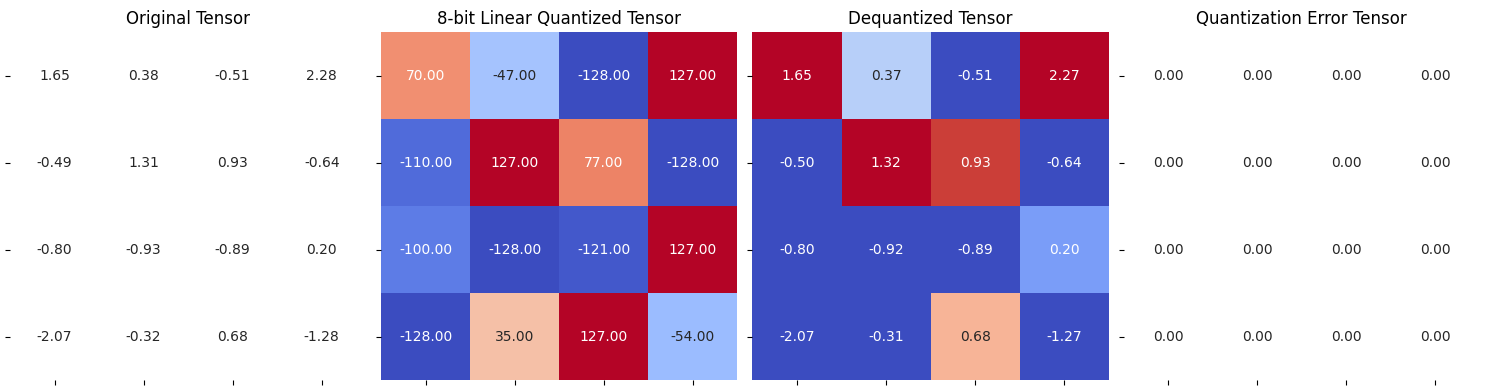

tensor(8.9323e-06)

In [30]:
bt.get_batch_scales_and_zeropoints()
bt.linear_batch_quantization()
bt.linear_batch_dequantization()
plot_quantization_errors(bt.tensor, bt.quantized_tensor, bt.dequantized_tensor)
bt.batch_quantization_mse()

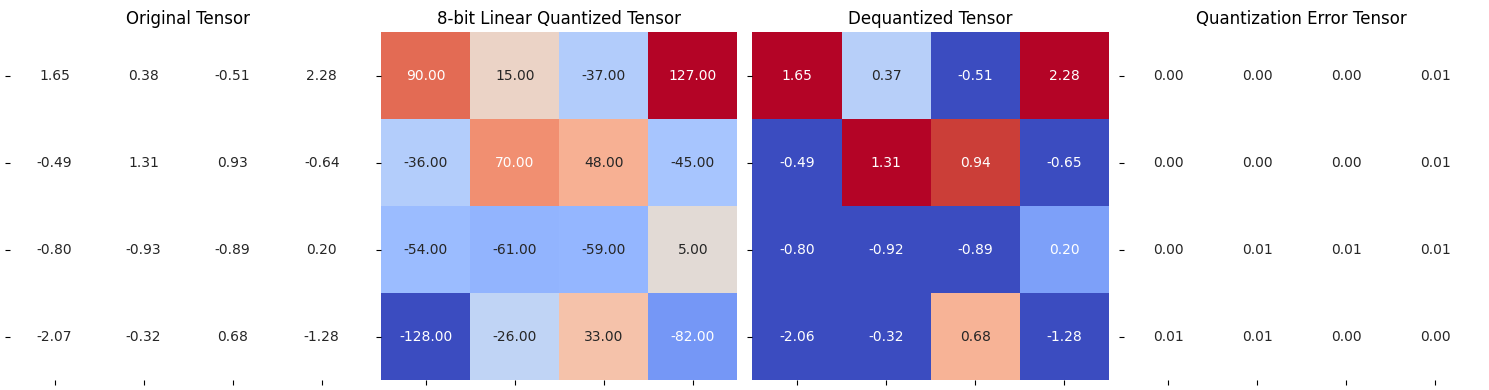

Quantization Mean Squared Error: 2.3107495508156717e-05


In [31]:
new_scale , new_zero_point = get_q_scale_and_zero_point(bt.tensor)
quantized_tensor = linear_q_with_scale_and_zero_point(bt.tensor, new_scale, new_zero_point)
dequantized_tensor = linear_dequantization(quantized_tensor, new_scale, new_zero_point)
plot_quantization_errors(bt.tensor, quantized_tensor,dequantized_tensor)
quantization_mse(dequantized_tensor, bt.tensor)

# <font color=orange>Linear Quantization II-A: Symmetric vs. Asymmetric Mode</font>
In this lesson, you will learn a different way of performing linear quantization, Symmetric Mode.

There are **two** modes in linear quantization
* **Asymmetric**: We map [$r_{min}, r_{max}$] to [$q_{min}, q_{max}$] (*What was implemented previously*)
* **Symmetric**: We map [$-r_{min}, r_{max}$] to [$-q_{min}, q_{max}$], where we can set $r_{max} = max(|r_{tensor}|)$
    * We don't need to use zero point ($z=0$), beacuse the floating point range and the quantized range are symmetric with respect to zero
    * Hence, We can simplify the equations to:
    * $q = int(round(r/s))$
    * $s = r_{max}/q_{max}$

In [32]:
import torch
from helper import plot_quantization_errors

In [33]:
def get_q_scale_symmetric(tensor, dtype=torch.int8):
    r_max = tensor.abs().max().item()
    q_max = torch.iinfo(dtype).max
    return r_max / q_max

In [34]:
test_tensor = torch.rand((4,4))
test_tensor

tensor([[0.9015, 0.7384, 0.9856, 0.4048],
        [0.7046, 0.3151, 0.7113, 0.6313],
        [0.1091, 0.2107, 0.2368, 0.1621],
        [0.7975, 0.2930, 0.9705, 0.3118]])

In [35]:
get_q_scale_symmetric(test_tensor)

0.007760286331176758

In [36]:
def linear_q_symmetric(tensor, dtype=torch.int8):
    scale = get_q_scale_symmetric(tensor)
    quantized_tensor = linear_q_with_scale_and_zero_point(tensor, scale=scale, zero_point=0, dtype=dtype)
    return quantized_tensor, scale    

In [37]:
quantized_tensor, scale = linear_q_symmetric(test_tensor)

In [38]:
dequantized_tensor = linear_dequantization(quantized_tensor, scale, 0)

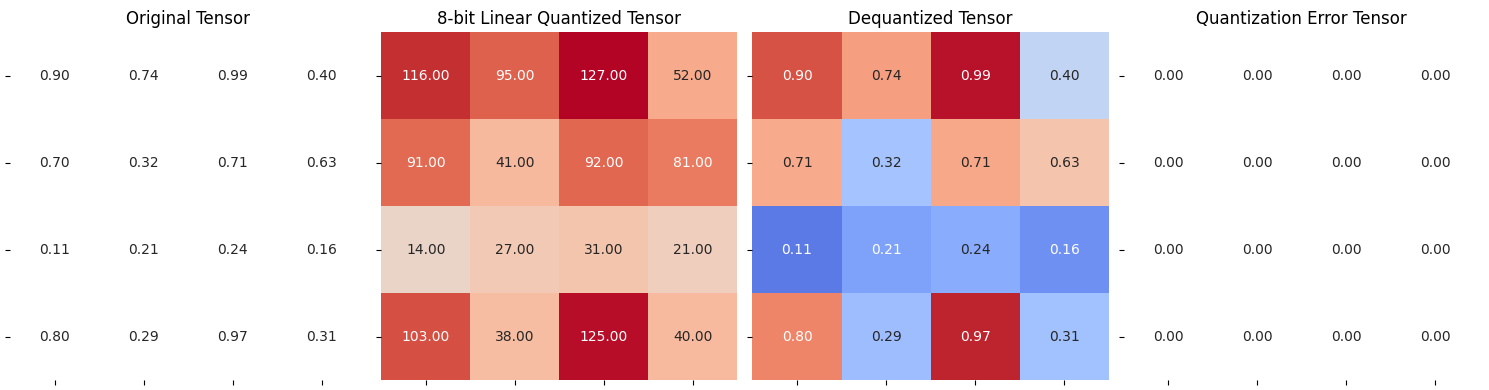

Quantization Mean Squared Error: 3.5454504541121423e-06


In [39]:
plot_quantization_errors(test_tensor, quantized_tensor, dequantized_tensor)
quantization_mse(dequantized_tensor, test_tensor)

Trade-Offs:
* **Utilization of Quantized Range**
    * Asymmetric quantization fully utilizes the quantized range
    * Symmetric mode will dedicate values of the quantized range to unnecessary values if the float range is biased towards one side. (e.g. RELU where the output is always positive)
*  **Simplicity**
    * Symmetric mode is much simpler and straightforward then Assymetric mode
*  **Memory**
    * Zero-points are not stored which saves memory    

# <font color=orange>Linear Quantization II-B: Finer Granularity for more Precision</font>
In this lesson, you will learn about different granularities of performing linear quantization.

### Per Tensor Quantization:

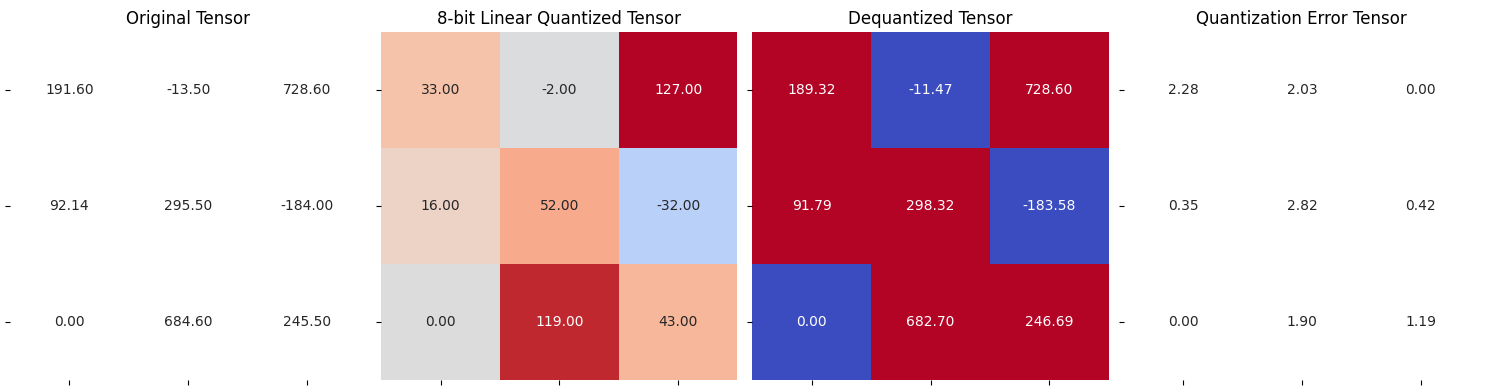

Quantization Mean Squared Error: 2.5091912746429443


In [40]:
test_tensor=torch.tensor(
    [[191.6, -13.5, 728.6],
     [92.14, 295.5,  -184],
     [0,     684.6, 245.5]]
)

quantized_tensor, scale = linear_q_symmetric(test_tensor)
dequantized_tensor = linear_dequantization(quantized_tensor, scale, 0)
plot_quantization_errors(test_tensor, quantized_tensor, dequantized_tensor)
quantization_mse(dequantized_tensor, test_tensor)

### Per Channel Quantization:

In [41]:
test_tensor=torch.tensor(
    [[191.6, -13.5, 728.6],
     [92.14, 295.5,  -184],
     [0,     684.6, 245.5]]
)

In [42]:
dim=0 # dim=0 means along rows, dim=1 means along columns
output_dim = test_tensor.shape[dim]
output_dim

3

In [43]:
scale = torch.zeros(output_dim)
scale

tensor([0., 0., 0.])

In [44]:
for i in range(output_dim):
    sub_tensor = test_tensor.select(dim, i)
    scale[i] = get_q_scale_symmetric(sub_tensor)
scale

tensor([5.7370, 2.3268, 5.3906])

In [45]:
scale_shape = [1] * test_tensor.dim()
scale_shape

[1, 1]

In [46]:
scale_shape[dim]=-1
scale_shape

[-1, 1]

In [47]:
scale = scale.view(scale_shape)
scale

tensor([[5.7370],
        [2.3268],
        [5.3906]])

In [48]:
scale.shape

torch.Size([3, 1])

In [49]:
quantized_tensor = linear_q_with_scale_and_zero_point(test_tensor, scale=scale, zero_point=0)
quantized_tensor

tensor([[ 33,  -2, 127],
        [ 40, 127, -79],
        [  0, 127,  46]], dtype=torch.int8)

In [50]:
def linear_q_symmetric_per_channel(r_tensor, dim, dtype=torch.int8):
    
    output_dim = r_tensor.shape[dim]
    # store the scales
    scale = torch.zeros(output_dim)

    for index in range(output_dim):
        sub_tensor = r_tensor.select(dim, index)
        scale[index] = get_q_scale_symmetric(sub_tensor, dtype=dtype)

    # reshape the scale
    scale_shape = [1] * r_tensor.dim()
    scale_shape[dim] = -1
    scale = scale.view(scale_shape)
    quantized_tensor = linear_q_with_scale_and_zero_point(
        r_tensor, scale=scale, zero_point=0, dtype=dtype)
   
    return quantized_tensor, scale

In [51]:
test_tensor=torch.tensor(
    [[191.6, -13.5, 728.6],
     [92.14, 295.5,  -184],
     [0,     684.6, 245.5]]
)

In [52]:
### along the rows (dim = 0)
quantized_tensor_0, scale_0 = linear_q_symmetric_per_channel(test_tensor, dim=0)

### along the columns (dim = 1)
quantized_tensor_1, scale_1 = linear_q_symmetric_per_channel(test_tensor, dim=1)

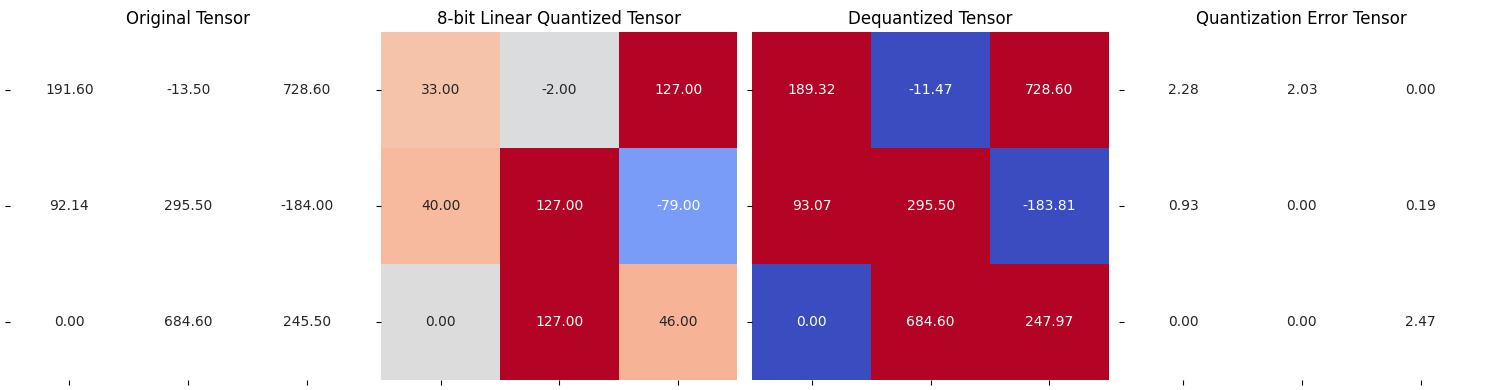

Quantization Mean Squared Error: 1.8084441423416138


In [53]:
dequantized_tensor_0 = linear_dequantization(quantized_tensor_0, scale_0, 0)
plot_quantization_errors(test_tensor, quantized_tensor_0, dequantized_tensor_0)
quantization_mse(dequantized_tensor_0, test_tensor)

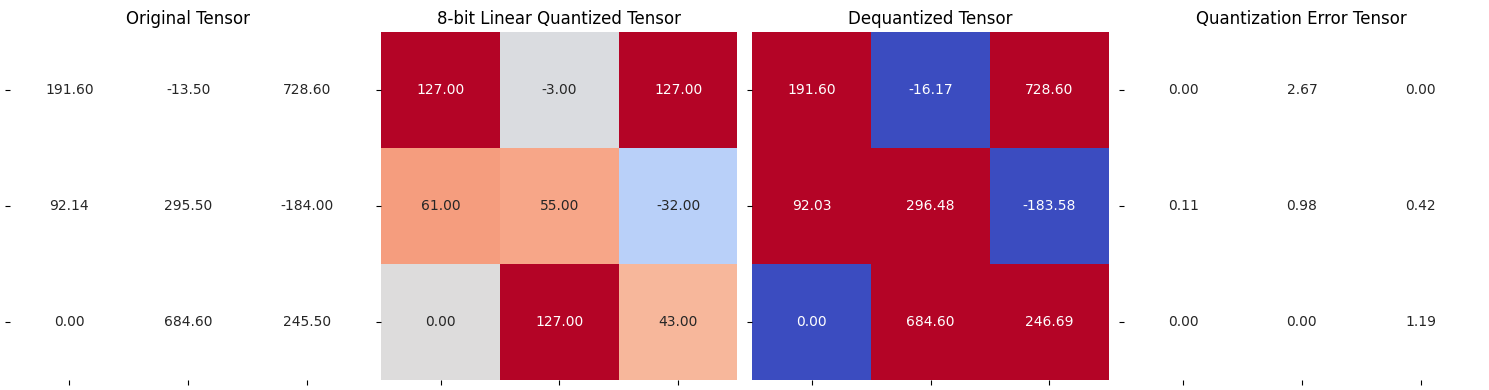

Quantization Mean Squared Error: 1.0781488418579102


In [54]:
dequantized_tensor_1 = linear_dequantization(quantized_tensor_1, scale_1, 0)
plot_quantization_errors(test_tensor, quantized_tensor_1, dequantized_tensor_1, n_bits=8)
quantization_mse(dequantized_tensor_1, test_tensor)

### Per Group Quantization:

In [55]:
def linear_q_symmetric_per_group(tensor, group_size, dtype=torch.int8):
    t_shape = tensor.shape
    assert t_shape[1] % group_size == 0
    assert tensor.dim()==2
    tensor = tensor.view(-1, group_size)
    quantized_tensor, scale = linear_q_symmetric_per_channel(tensor, dim=0, dtype=dtype)
    quantized_tensor = quantized_tensor.view(t_shape)
    return quantized_tensor, scale

In [56]:
def linear_dequantization_per_group(quantized_tensor, scale, group_size):
    q_shape = quantized_tensor.shape
    quantized_tensor = quantized_tensor.view(-1, group_size)
    dequantized_tensor = linear_dequantization(quantized_tensor, scale, 0)
    dequantized_tensor = dequantized_tensor.view(q_shape)
    return dequantized_tensor

In [57]:
test_tensor = torch.rand((6,6))

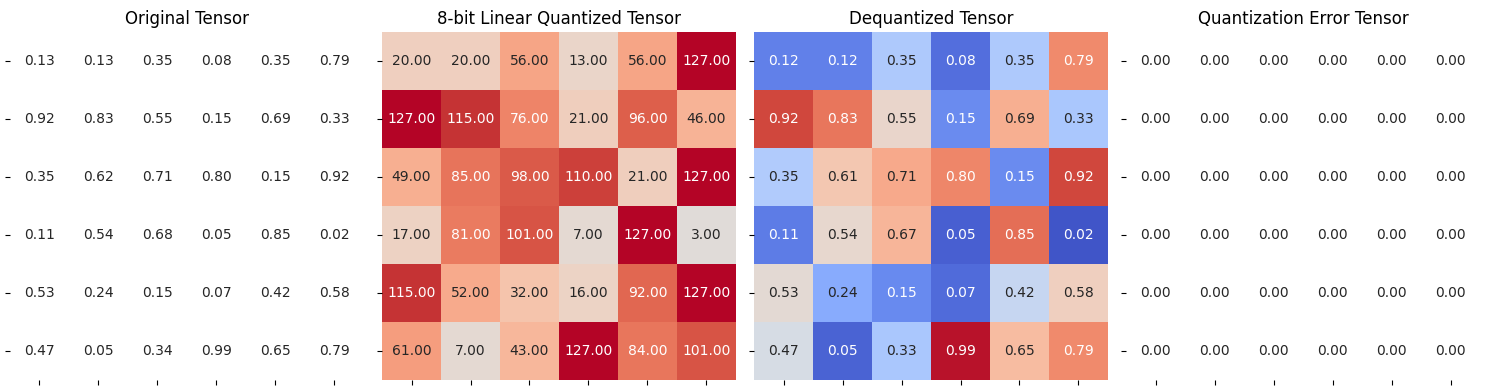

Quantization Mean Squared Error: 2.448641453156597e-06


In [58]:
group_size = 6
quantized_tensor, scale = linear_q_symmetric_per_group(test_tensor, group_size=group_size)
dequantized_tensor = linear_dequantization_per_group(quantized_tensor, scale, group_size=group_size)
plot_quantization_errors(test_tensor, quantized_tensor, dequantized_tensor)
quantization_mse(dequantized_tensor, test_tensor)

# <font color=orange>Linear Quantization II-C: Quantizing Weights & Activations for Inference</font>

In a NN we can quantize the **weights** *and* **activations** >> depending on what is quantized, the **storage** and **computation** are not the same:
* **Storage** = Quantized Weight + Activation (e.g. W8A32) >> **Computation** = Floating Point arithmetic (FP32, FP16, BF16...)
* **Storage** = Quantized Weight + Quantized Activation (e.g. W8A8) >> **Computation** = Integer based arithmetic (Int8, Int4...)

In [59]:
def quantized_linear_W8A32_without_bias(input, q_w, s_w, z_w):
    assert input.dtype == torch.float32
    assert q_w.dtype == torch.int8

    dequantized_weight = q_w.to(torch.float32) * s_w + z_w
    output = torch.nn.functional.linear(input, dequantized_weight)
    
    return output

In [60]:
input = torch.tensor([1,2,3], dtype=torch.float32)
weight = torch.tensor([[-2,   -1.13, 0.42],
                       [-1.51, 0.25, 1.62],
                       [0.23,  1.35, 2.15]])

In [61]:
q_w, s_w  = linear_q_symmetric(weight)
q_w

tensor([[-118,  -67,   25],
        [ -89,   15,   96],
        [  14,   80,  127]], dtype=torch.int8)

In [62]:
s_w

0.016929134609192376

In [63]:
output = quantized_linear_W8A32_without_bias(input, q_w, s_w, 0)
print(f"This is the W8A32 output: {output}")

This is the W8A32 output: tensor([-2.9965,  3.8768,  9.3957])


In [64]:
fp32_output = torch.nn.functional.linear(input, weight)
print(f"This is the output if we don't quantize: {fp32_output}")

This is the output if we don't quantize: tensor([-3.0000,  3.8500,  9.3800])


# <font color=orange>Building your own Quantizer: Custom Build an 8-Bit Quantizer</font>
In this lesson, you will learn how to compress any model in 8-bit precision leveraging past tools. This Quantizer is Model Agnostic.
* Create a 'W8A16LinearLayer' class to store 8-bit weights and scales
* Replace all 'torch.nn.linear' layers with 'W8A16LinearLayer'
* Build Quantizer and quantize the model end-to-end
* Testing the naive absmax quantization on many scenarios and study the impact